In [1]:
import pandas as pd
import numpy as np

# from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath

import re
import nltk
from nltk.tokenize import word_tokenize
from razdel import tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrleg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrleg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Функции:

In [2]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
#     text = text.strip('\n').strip('\r').strip('\t')
#     text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n|n", ' ', text)
#     text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
#     print(text)
    
    tokens = list(word_tokenize(text))
#     print(tokens)
#     words = [_.text for _ in tokens]
    tokens = [w for w in tokens if w not in stopword_ru]
#     print(tokens)
    
    return " ".join(tokens)

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [3]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [62]:
def analyze_method(method, method_idx):    
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: method(x), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

    X = pd.merge(user_embeddings, target, 'left')
    X.head(3)

    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                        X['churn'], random_state=0)

    logreg = LogisticRegression()
    #обучим 
    logreg.fit(X_train, y_train)

    preds = logreg.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}\n')

    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                                      title='Confusion matrix')
    plt.show()

    print(f'\nROC_AUC score: {roc_auc_score(y_test, preds)}')

    # соберем всю статистику по модели в словарь
    final_results['precision'].insert(method_idx, round(precision[ix], 4))
    final_results['precision'].pop(method_idx+1)
    final_results['recall'].insert(method_idx, round(recall[ix], 4))
    final_results['recall'].pop(method_idx+1)
    final_results['roc_auc'].insert(method_idx, round(roc_auc_score(y_test, preds), 4))
    final_results['roc_auc'].pop(method_idx+1)
    final_results['f_score'].insert(method_idx, round(fscore[ix], 4))
    final_results['f_score'].pop(method_idx+1);

In [63]:
# Функция формирует "вектор пользователя"
# Берутся статьи которые читал пользователь (их вектора вероятностей принадлежности к топикам/классам)
# По эррею векторов берется СРЕДНЕЕ, МЕДИАНА и МАКСИМУМ

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

## Обработка данных

In [5]:
news1234 = pd.read_csv("articles.csv")
news1234['title'][0]

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [6]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [7]:
users = pd.read_csv("users_articles.csv")
print(news.shape)
users.head(3)

(27000, 2)


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [8]:
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

In [9]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-2-c5503b3260cd>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 2min 15s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 45s


In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = news['title'].values

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)

In [14]:
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [16]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 50.8 s


In [17]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это']


[(0, 0.07435545),
 (4, 0.14591211),
 (5, 0.18869483),
 (14, 0.027300479),
 (19, 0.116166845),
 (20, 0.40403384),
 (23, 0.025964735)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic, words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год который университет свой время риск планета
topic_1: статья гражданин поверхность россия депутат автор министерство
topic_2: пациент взрыв высота долг фронт гражданин вода
topic_3: продукция рейс перевод юрист законодательство задержка убивать
topic_4: это рост год говорить наш россия который
topic_5: журнал это население регион исследование область наука
topic_6: экономика пенсия фотография кровь бензин риск подчёркивать
topic_7: исследование научный прогноз год который способность связанный
topic_8: проект год который новый ракета земля компания
topic_9: который санкция российский документ россия рф закон
topic_10: украина газ россия украинский страна киев москва
topic_11: отряд форум больной австралия la австралийский крыша
topic_12: военный армия операция турция путин боевой россия
topic_13: год рубль млн млрд который компания тыс
topic_14: снижение двигатель запуск треть метод рынок ступень
topic_15: сша россия американский российский это китай эксперт
topic_16: район

In [20]:
# Получаем матрицу. Строки - определенные документы и их вероятность принадлежности к определенному топику
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.67386,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.051158,...,0.165284,0.055436,0.000000,0.0,0.00000,0.000000,0.046545,0.0,0.000000,0.000000
1,4896,0.000000,0.00000,0.323557,0.0,0.000000,0.170511,0.0,0.0,0.000000,...,0.000000,0.000000,0.209506,0.0,0.00000,0.110672,0.165226,0.0,0.000000,0.000000
2,4897,0.067814,0.00000,0.000000,0.0,0.140359,0.180139,0.0,0.0,0.043565,...,0.000000,0.000000,0.000000,0.0,0.11911,0.404103,0.000000,0.0,0.000000,0.000000
3,4898,0.000000,0.00000,0.000000,0.0,0.247050,0.204394,0.0,0.0,0.000000,...,0.000000,0.105462,0.000000,0.0,0.20066,0.117839,0.000000,0.0,0.057130,0.000000
4,4899,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.714303,0.203243


In [21]:
# Датафрейм пользователей. Строки - пользователь + прочитанные им статьи
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [22]:
# Формируем словарь статей (документов)
# Ключ - айди документа/статьи
# Значение - нампай эррей вероятностей принадлежности статьи к определенному классу
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [23]:
doc_dict[323329]

array([0.        , 0.16340159, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02141012, 0.        , 0.40646765,
       0.        , 0.        , 0.02212488, 0.        , 0.        ,
       0.22180985, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15614191])

# Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [24]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [47]:
final_results = {
    'methods': ['mean', 'median', 'max'],
    'precision': [0 for _ in range(3)], 
    'recall': [0 for _ in range(3)], 
    'f_score': [0 for _ in range(3)], 
    'roc_auc': [0 for _ in range(3)], 
}

## get_user_embedding (mean)

Best Threshold=0.28432921057067945, F-Score=0.685, Precision=0.662, Recall=0.710

Confusion matrix, without normalization
[[1666   89]
 [  72  173]]


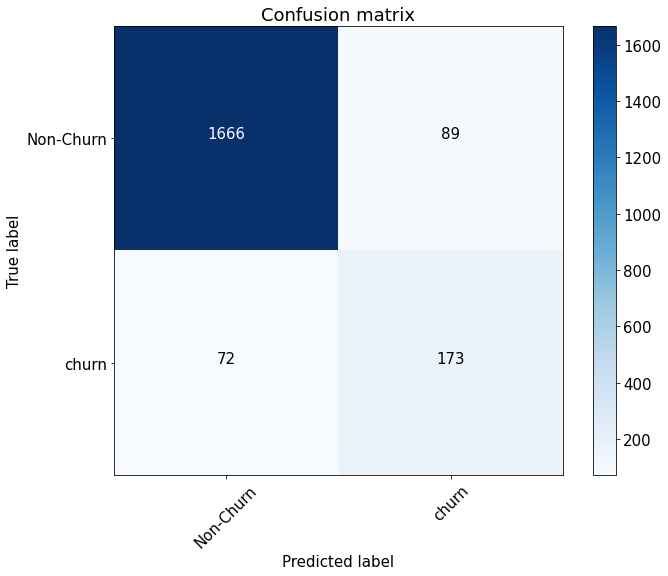


ROC_AUC score: 0.9496110238967381


In [61]:
analyze_method(get_user_embedding, 0)

## get_user_embedding (median)

Best Threshold=0.2821516805025973, F-Score=0.752, Precision=0.720, Recall=0.788

Confusion matrix, without normalization
[[1680   75]
 [  53  192]]


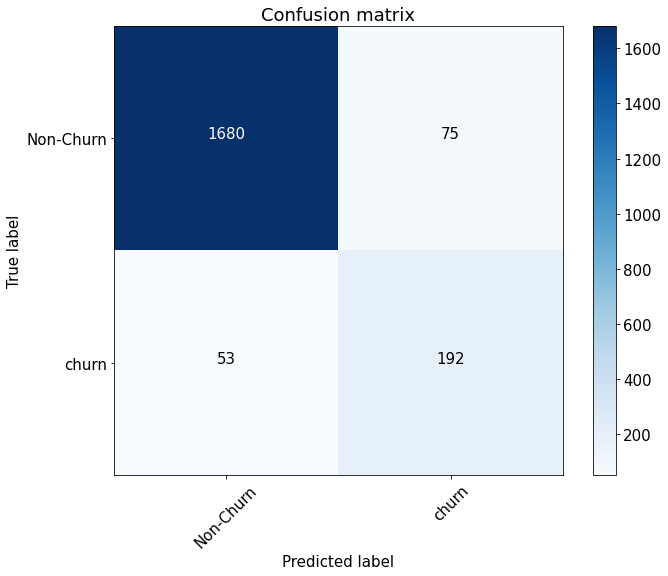


ROC_AUC score: 0.9714495028780742


In [64]:
analyze_method(get_user_embedding_median, 1)

В отличии от среднего, мы получили больше нулей, так как медиана лежит в середине отсортированного распределения. Вполне вероятно, что она вернула нам нули в те топики, статьи к которым чаще всего НЕ относились (вероятность принадлежности большинства статей к этим топикам была нулевая)  
  
Часто медиану считают более репрезентативной, чем среднее и не зря :)

## get_user_embedding (max)

Best Threshold=0.3426700093421938, F-Score=0.844, Precision=0.836, Recall=0.853

Confusion matrix, without normalization
[[1714   41]
 [  37  208]]


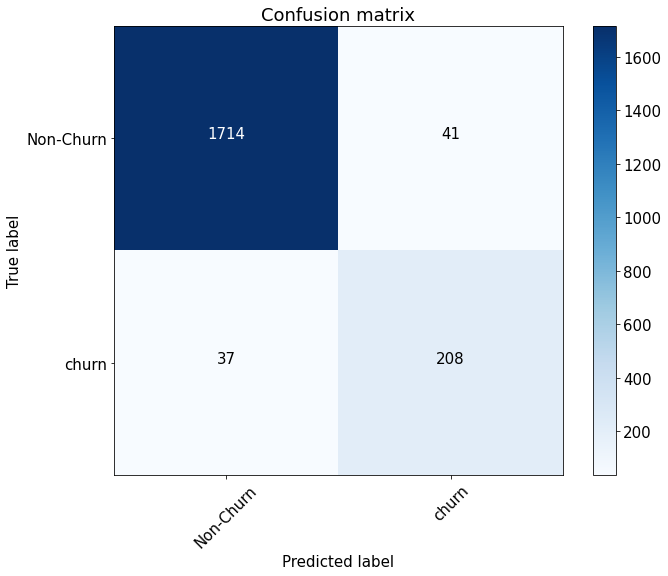


ROC_AUC score: 0.9861968719111576


In [65]:
analyze_method(get_user_embedding_max, 2)

Максимум вернул нам самый "жирный" вектор вероятностей принадлежности статьи к топикам. Честно говоря, не особо понимаю, как это было посчитано, ибо все вектора должны равняться единицам

## Выводы:

In [58]:
df_results = pd.DataFrame(final_results)
df_results.set_index('methods')

,precision,recall,f_score,roc_auc
methods,,,,
mean,0.6616,0.7102,0.6850,0.9496
median,0.7201,0.7878,0.7524,0.9714
max,0.8360,0.8531,0.8444,0.9862


Лучше всего, на удивление, справился метод, использующий "максимальный" вектор эмбедингов пользователя. Видимо, np.max() сравнивает каждое значение векторов и возвращает тот, в котором наибольшее количество наибольших значений  
  
Соответственно, такой вектор будет самым репрезентативным и модель обученная на таких данных будет лучше предсказывать и реже ошибаться

***
С tfidf к сожалению, пока не успеваю разобраться, сохранил в закладках, позже вернусь)